# Import necessary packages

In [2]:
import os
isColab= 'google.colab' in str(get_ipython())
if isColab:
  ! pip install qutip

import numpy as np
from qutip import *

from numpy import sqrt, pi
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams.update({'font.size': 18})
import matplotlib.pyplot as plt
from tqdm import tqdm

import scipy.sparse as sp
import scipy.linalg as la
from scipy.sparse.linalg import spsolve
if qutip.settings.has_mkl:
    from qutip._mkl.spsolve import mkl_spsolve


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Understanding the dressed qubit (nonlinear oscillator)

Our approach will consist on dressing the qubit states with the laser, enabling non-number conserving interactions with the cavity. Here, we will see that if $\Omega_q > U$, we will be seeing higher levels in the qubit. If we want to keep a simple description based on a qubit, $U$ will set a limit to the power with which we drive the qubit. We can still see interesting things for higher powers, but we loose the qubit description and the physics becomes messier.

In [3]:
Nqubit = 7
b = destroy(Nqubit)

def gen_H_qubit(params_H:list):
  # This function generates a Hamiltonian in the rotating frame of the drive.
  # Both qubit and cavity can be directly driven in this scheme 

  Delta_q, U, Omega_q = params_H
  H = (Delta_q*b.dag()*b + U*b.dag()*b.dag()*b*b + Omega_q*(b.dag()+b))
  return H

In [4]:
Omega_q_min = 0.; Omega_q_max = 200; nOmega = 100;
Omega_q_list = np.linspace(Omega_q_min, Omega_q_max, nOmega)

U = -100

In [5]:
eigen_Omega = np.asarray([gen_H_qubit([0., U, Omega_q]).eigenenergies() for Omega_q in Omega_q_list])
eigen_Omega.shape

(100, 7)

Here we see that for $\Omega_q \ll U$ (with U the red line), the states $|0\rangle$ and $|1\rangle$ are dressed, while the higher states stay pretty much the same.

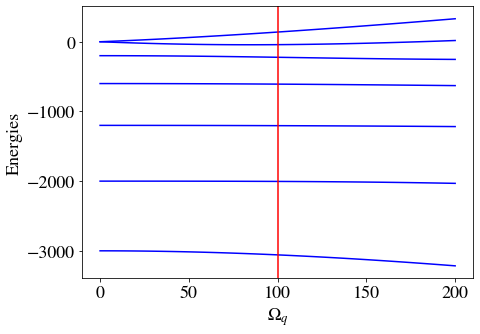

In [6]:
fig, ax = plt.subplots(figsize= (7,5))
for idx in range(Nqubit):
  ax.plot(Omega_q_list, eigen_Omega[:,idx], 'b-')
ax.set_xlabel("$\Omega_q$"); ax.set_ylabel("Energies")
ax.axvline(x=np.abs(U), color='red')
plt.show()

In [7]:
Omega_q = 10
vac_q = basis(Nqubit,0)

tini = 0.; tfin = 4*2*pi/Omega_q; nt = 1000; times = np.linspace(tini, tfin, nt)
H = gen_H_qubit([0., U, Omega_q])
                
result = mesolve(H, rho0 = vac_q,  tlist = times, c_ops = [])

In [8]:
def pop_time_index(idx, result):
  return [np.squeeze(np.abs(psi[idx])**2) for psi in result.states]

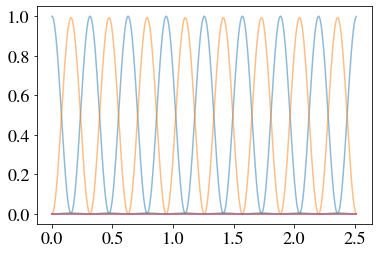

In [9]:
for idx in range(Nqubit):
  plt.plot(times, pop_time_index(idx,result), alpha = 0.5)

plt.show()

# Define the system

We will define a cavity with annihilation operator $\hat a$, and a qubit given by a cavity with annihilation operator $\hat b$ and a Kerr-type nonlinearity $U$.

In [10]:
Ncav = 3     # Truncation number in the cavity 
Nqubit = 3    # Trunction number in the qubit-cavity

a = tensor(destroy(Ncav), qeye(Nqubit))
b = tensor(qeye(Ncav), destroy(Nqubit))

vac = tensor(basis(Ncav,0), basis(Nqubit,0))

We define a function to create the following Hamiltonian, in the rotating frame of a coherent drive:

$ \hat H = \Delta_a \hat a^\dagger \hat a + \Delta_q \hat b ^\dagger \hat b 
+ U \hat b^\dagger \hat b^\dagger \hat b \hat b + g(\hat a^\dagger \hat b + \hat a \hat b^\dagger )  + \Omega_a (\hat a + \hat a^\dagger) + \Omega_q(\hat b + \hat b^\dagger)$

We assume:


1.  Qubit described by Kerr cavity
2.   Jaynes-Cummings interaction




In [11]:
def gen_Hamiltonian(params_H:list):
  # This function generates a Hamiltonian in the rotating frame of the drive.
  # Both qubit and cavity can be directly driven in this scheme 

  Delta_q, Delta_a, g, U, Omega_a, Omega_q = params_H
  H = (Delta_a * a.dag()*a + Delta_q*b.dag()*b + U*b.dag()*b.dag()*b*b +
       g*(a.dag()*b + b.dag()*a) 
  + Omega_a*(a.dag()+a) + Omega_q*(b.dag()+b))
  return H

In [12]:
def gen_Liouv(params_H:list, params_L: list):
  # params_H : Hamiltonian_parameters
  # param_L : Dissipative parameters (losses, dephasing)
  H = gen_Hamiltonian(params_H)
  kappa, gamma_q, gamma_phi = params_L
  c_ops = [sqrt(kappa)*a, sqrt(gamma_q)*b, sqrt(gamma_phi)*b.dag()*b]
  return liouvillian(H, c_ops)

In [117]:
# System parameters in MHz
U = -100 # MHz
g = 1 

kappa = 0.5
gamma_phi = 0.5
gamma_q = 0.05

Delta_q = 0
Delta_a = 10*g

In [119]:
Omega_q = 20*g;
Omega_a = 0.;

params_H = Delta_q, Delta_a, g, U, Omega_a, Omega_q 
params_L = kappa, gamma_q, gamma_phi

L = gen_Liouv(params_H, params_L)
rho_ss = steadystate(L)
liouvM=L.data
h2 = liouvM.shape[0] # Hilbert size ^2
rhs= ((rho_ss*(a.dag()))).data.reshape((h2,1))

In [120]:
id = sp.identity(h2)
omega = 0.3;
1j*id*omega

<81x81 sparse matrix of type '<class 'numpy.complex128'>'
	with 81 stored elements (1 diagonals) in DIAgonal format>

In [121]:
def Spectrum(omega, liouv, a, rhs = None):
  liouvM=liouv.data
  h2 = liouvM.shape[0] # Hilbert size ^2
  id = sp.identity(h2)

  if rhs ==None:
    rho_ss = steadystate(liouv)
    rhs= ((rho_ss*(a.dag()))).data.reshape((h2,1))

  v = spsolve(liouvM + 1j*id*omega, rhs)
  rho_eff=vec2mat(v)
  aM = a.data
  return -np.real(np.trace(aM*rho_eff))/pi

In [128]:
omega_min = -2*Omega_q; omega_max = -omega_min; nomega = 400
omega_grid = np.linspace(omega_min, omega_max, nomega)

In [129]:
spectrum = np.asarray([Spectrum(omega, L, a, rhs) for omega in omega_grid])

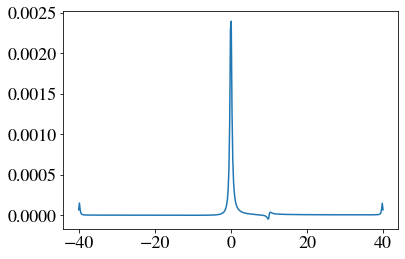

In [130]:
plt.plot(omega_grid, spectrum)
plt.show()

In [131]:
eigen_vecs=L.eigenstates()
E = np.transpose(np.reshape(
    np.array([eigen_vecs[1][i].full() for i in range(h2)]), 
    (h2,h2)))
Einv = np.linalg.inv(E)
EinvTr = Einv.T
eigvals = eigen_vecs[0]
Einvrhs=EinvTr@rhs

In [132]:
aM = a.data
spectrum=np.asarray([-np.real((aM*vec2mat((E@((1/(eigvals + 1j*omega))*EinvTr).T)@rhs)).trace())/pi for omega in omega_grid])

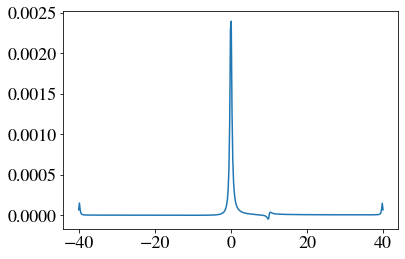

In [133]:
plt.plot(omega_grid, spectrum)
plt.show()